In [1]:
# read in data
import pandas as pd
import numpy as np
indian_food = pd.read_csv('indian_food.cs',sep=",",engine='python',index_col=0)
region = indian_food['region'].to_numpy()
print(set(region))
print(indian_food.columns)

{'-1', nan, 'East', 'Central', 'North East', 'North', 'South', 'West'}
Index(['ingredients', 'diet', 'prep_time', 'cook_time', 'flavor_profile',
       'course', 'state', 'region'],
      dtype='object')


In [2]:
# remove nan and -1 from region
indian_food = indian_food.dropna()
indian_food = indian_food[indian_food['region'] != '-1']
# remove -1 from features that will be used
indian_food = indian_food[indian_food['flavor_profile'] != '-1']
indian_food = indian_food[indian_food['diet'] != '-1']
indian_food = indian_food[indian_food['course'] != '-1']
indian_food = indian_food[indian_food['prep_time'] != -1]
indian_food = indian_food[indian_food['cook_time'] != -1]

region = indian_food['region'].to_numpy()
ingredients = indian_food['ingredients'].to_numpy()
N = len(set(region)) # num of classes
print(indian_food.shape)

(242, 8)


In [3]:
# Maps region to int
def mapper(s):
    if s=='North East':
        return 0
    elif s=='West':
        return 1
    elif s=='Central':
        return 2
    elif s=='North':
        return 3
    elif s=='East':
        return 4
    else: # South
        return 5

In [4]:
# Multinomial Naive Bayes implementation
# loop over train ingredients
def create_word_dictionary():
    word_dictionary = {}
    for i in range(len(x_train)):
        words = x_train[i].lower().split(", ")
        for w in words:
            if w not in word_dictionary:
                word_dictionary[w] = [1,1,1,1,1,1]
            word_dictionary[w][training_labels[i]] += 1
    return word_dictionary


# What is the prior? P(Y=region)
def get_priors(train_labels):
    label_counts = np.zeros(N)
    for l in train_labels:
        label_counts[l] += 1
    train_count = len(train_labels)
    priors = [label_counts[i]/train_count for i in range(N)]
    return priors


# What are the class probabilities P(X=food|Y=region) for each ingredient?
def get_region_likelihoods(counts):
    region_likelihood = {}
    for i in range(N):
        region_likelihood[i] = {}
    for key,val in food_dictionary.items():
        for i in range(N):
            region_likelihood[i][key] = val[i]/counts[i]*1.0
    return region_likelihood


def get_posteriors(x):
    posteriors = np.zeros((len(x),N))
    for i in range(len(x)):
        p = [np.log(prior) for prior in priors]
        foods = x[i].lower().split(", ") 
        for f in foods:
            try:
                p = [p[i] + np.log(region_likelihood[i][f]) for i in range(N)]
            except KeyError:
                pass
        # none of the test ingredients found in training
        if sum(p) == 0:
            post_denom = 1
        else:
            post_denom = sum(p)
        for j in range(N):
            posteriors[i,j] = p[j]
    return posteriors


# Get test set accuracy
def validate_model(posteriors, labels):
    prediction_labels = np.zeros(len(labels))
    correct = 0
    # the larger posterior value is more probable
    for i in range(len(labels)):
        prob = posteriors[i]
        pred_region = np.argmax(prob)
        prediction_labels[i] = pred_region
        if pred_region == labels[i]:
            correct += 1
    print("Accuracy: " + str(correct/len(labels)*100.0) + "%")
    return prediction_labels

In [5]:
# train classifier
import sklearn.model_selection as ms
# split by indices
all_indices = list(range(len(indian_food)))
train_indices, test_indices = ms.train_test_split(all_indices, test_size=0.2, random_state=0)
train = indian_food.iloc[train_indices]
test = indian_food.iloc[test_indices]
x_train,x_test = train['ingredients'], test['ingredients']
y_train,y_test = train['region'], test['region']
training_labels = [mapper(w) for w in y_train]
y_test_labels = [mapper(w) for w in y_test]

food_dictionary = create_word_dictionary()
total_word_counts = np.array([v for v in food_dictionary.values()]).sum(axis=0)
priors = get_priors(training_labels)
region_likelihood = get_region_likelihoods(total_word_counts) # region_likelihood[region_num][food] = prob
posteriors_train = get_posteriors(x_train)
validate_model(posteriors_train, training_labels)

posteriors_test = get_posteriors(x_test)
y_pred = validate_model(posteriors_test, y_test_labels)


Accuracy: 87.04663212435233%
Accuracy: 55.10204081632652%


(7, 0)

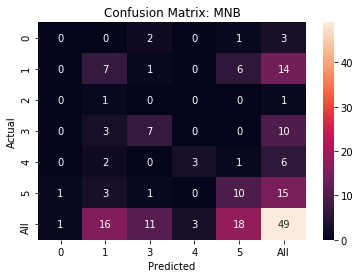

In [6]:
# examine predictions
import seaborn as sn
data = {'y_Actual':    y_test_labels,
        'y_Predicted': [int(y) for y in y_pred]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

ax = sn.heatmap(confusion_matrix, annot=True)
# print(ax.get_ylim())
ax.title.set_text('Confusion Matrix: MNB')
ax.set_ylim(7, 0)

In [7]:
# model revision 1:
# more features
# add in flavor_profile, diet, prep time, cook time
# add in prep and cook time
# discretize prep and cook time w/ WPKID

m = 30
n = len(x_train)
# n = s * t
# t = s - m
# s = t + m
# n = (t + m) * t = t**2 + m*t
# 0 = t**2 + m*t - n
# solve for t
p = [1, m, -n]
t = int(max(np.roots(p)))
# print(t)
s = t + m
# print(s)
# [0-35, 35-70, 70-105, 105-140, 140+]
intervals = [s*i for i in range(1,t)]
# print(intervals)
indian_food['prep_time'] = np.digitize(indian_food['prep_time'],intervals)
indian_food['prep_time'] = indian_food['prep_time'].map(str)
indian_food['cook_time'] = np.digitize(indian_food['cook_time'],intervals)
indian_food['cook_time'] = indian_food['cook_time'].map(str)

indian_food["full_description"] = indian_food["ingredients"] + ", " + indian_food["flavor_profile"] + ", " + indian_food["diet"] + ", " + indian_food["prep_time"] + ", " + indian_food['cook_time']

5
35
[35, 70, 105, 140]


In [8]:
train = indian_food.iloc[train_indices]
test = indian_food.iloc[test_indices]
x_train,x_test = train['full_description'], test['full_description']
y_train,y_test = train['region'], test['region']
training_labels = [mapper(w) for w in y_train]
y_test_labels = [mapper(w) for w in y_test]

food_dictionary = create_word_dictionary()
total_word_counts = np.array([v for v in food_dictionary.values()]).sum(axis=0)
priors = get_priors(training_labels)
region_likelihood = get_region_likelihoods(total_word_counts) # region_likelihood[region_num][food] = prob
posteriors_train = get_posteriors(x_train)
validate_model(posteriors_train, training_labels)

posteriors_test = get_posteriors(x_test)
y_pred = validate_model(posteriors_test, y_test_labels)

Accuracy: 81.86528497409327%
Accuracy: 57.14285714285714%


(7, 0)

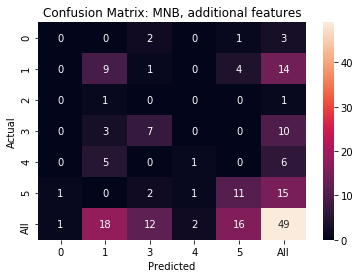

In [9]:
# examine predictions
data = {'y_Actual':    y_test_labels,
        'y_Predicted': [int(y) for y in y_pred]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

ax = sn.heatmap(confusion_matrix, annot=True)
# print(ax.get_ylim())
ax.title.set_text('Confusion Matrix: MNB, additional features')
ax.set_ylim(7, 0)

In [10]:
# Imbalanced classes
(unique, counts) = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

['Central' 'East' 'North' 'North East' 'South' 'West']
[ 2 24 42 19 46 60]


In [11]:
# CNB implementation
def get_not_counts(counts):
    total = np.sum(counts)
    not_counts = [total - c for c in counts]
    return not_counts

# P(X=food|Y=not region) for each ingredient
def get_region_likelihoods_cnb(counts):
    not_counts = get_not_counts(counts)
    region_likelihood = {}
    for i in range(N):
        region_likelihood[i] = {}
    for key,val in food_dictionary.items():
        not_val = get_not_counts(val)
        for i in range(N):
            region_likelihood[i][key] = not_val[i]*1.0/not_counts[i]*1.0
    return region_likelihood

def get_posteriors_cnb(x):
    posteriors = np.zeros((len(x),N))
    for i in range(len(x)):
        p = np.zeros(len(priors))
        foods = x[i].lower().split(", ") 
        for f in foods:
            try:
                p = [p[i] + np.log(region_likelihood[i][f]*1.0) for i in range(N)]
            except KeyError:
                pass
        # none of the test ingredients found in training
        p = [np.log(priors[i]) - p[i] for i in range(len(p))]
        if sum(p) == 0:
            post_denom = 1
        else:
            post_denom = sum(p)
        for j in range(N):
            posteriors[i,j] = p[j]
    return posteriors

def validate_model_cnb(posteriors, labels):
    prediction_labels = np.zeros(len(labels))
    correct = 0
    # the larger posterior value is more probable
    for i in range(len(labels)):
        prob = posteriors[i]
        pred_region = np.argmax(prob)
        prediction_labels[i] = pred_region
        if pred_region == labels[i]:
            correct += 1
    print("Accuracy: " + str(correct/len(labels)*100.0) + "%")
    return prediction_labels

In [12]:
x_train,x_test = train['full_description'], test['full_description']
y_train,y_test = train['region'], test['region']
y_test_label = [mapper(w) for w in y_test]
training_labels = [mapper(w) for w in y_train]
y_test_labels = [mapper(w) for w in y_test]

food_dictionary = create_word_dictionary()
# word counts for each class
total_word_counts = np.array([v for v in food_dictionary.values()]).sum(axis=0)
priors = get_priors(training_labels)
region_likelihood = get_region_likelihoods_cnb(total_word_counts) # region_likelihood[region_num][food] = prob
posteriors_train = get_posteriors_cnb(x_train)
validate_model_cnb(posteriors_train, training_labels)

posteriors_test = get_posteriors_cnb(x_test)
y_pred = validate_model_cnb(posteriors_test, y_test_labels)
# best with CNB

Accuracy: 67.35751295336787%
Accuracy: 53.06122448979592%


(7, 0)

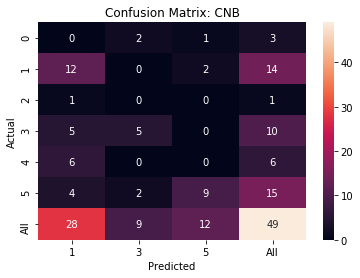

In [13]:
import seaborn as sn
data = {'y_Actual':    y_test_labels,
        'y_Predicted': [int(y) for y in y_pred]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

ax = sn.heatmap(confusion_matrix, annot=True)
# print(ax.get_ylim())
ax.title.set_text('Confusion Matrix: CNB')
ax.set_ylim(7, 0)
